This notebook is just to get a sense of the NIRSpec wavelength range covered.  It's not completely reproducible since it requires some random set of downloads for this JWST program but it should yield the gist that is needed.

In [1]:
from pathlib import Path
import copy

import numpy as np

from astropy import units as u

from tqdm.notebook import tqdm

from jwst import datamodels

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
jwst_dl_dir = Path('mastDownload/JWST')

nrsdirs = [p for p in jwst_dl_dir.glob('*nrs?') if p.is_dir()]

calfiles = []
for dir in nrsdirs:
    for p in dir.glob('*_cal.fits'):
        # filter out the guide star images
        if '_gs-' in p.name: 
            continue
            
        calfiles.append(p)
        
calfiles

[PosixPath('mastDownload/JWST/jw02609010001_02101_00002_nrs1/jw02609010001_02101_00002_nrs1_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609010001_02101_00001_nrs2/jw02609010001_02101_00001_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609010001_02101_00003_nrs2/jw02609010001_02101_00003_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609007001_03101_00002_nrs1/jw02609007001_03101_00002_nrs1_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609009001_04101_00001_nrs2/jw02609009001_04101_00001_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609008001_02101_00002_nrs2/jw02609008001_02101_00002_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609009001_04105_00001_nrs2/jw02609009001_04105_00001_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609009001_03101_00002_nrs1/jw02609009001_03101_00002_nrs1_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609009001_03101_00001_nrs2/jw02609009001_03101_00001_nrs2_cal.fits'),
 PosixPath('mastDownload/JWST/jw02609009001_03101_00003_nrs1/jw0

In [4]:
imwcses = []
slwcses = []
t = tqdm(calfiles)
for p in t:
    t.set_description(str(p))
    t.refresh()
    nrsnum = int(p.stem.split('_nrs')[-1].split('_')[0])
    with datamodels.open(p) as dm:
        if hasattr(dm, 'slits'):
            for sl in dm.slits:
                slwcses.append((copy.deepcopy(sl.meta.wcs), sl.data.shape, nrsnum))
        else:
            imwcses.append((copy.deepcopy(dm.meta.wcs), dm.data.shape, nrsnum))

  0%|          | 0/36 [00:00<?, ?it/s]

In [5]:
len(imwcses), len(slwcses)

(16, 1560)

In [6]:
wcseswwl = []
for w, s, n in imwcses:
    if 'em.wl' in w.world_axis_physical_types:
        wcseswwl.append((w, s, n))
for w, s, n in slwcses:
    if 'em.wl' in w.world_axis_physical_types:
        wcseswwl.append((w, s, n))
len(wcseswwl)

1560

In [7]:
w = wcseswwl[0][0]
s = wcseswwl[0][1]
px, py = np.meshgrid(np.arange(s[0]), np.arange(s[0]))
w.pixel_to_world(px, py), w.world_axis_physical_types

([<SkyCoord (ICRS): (ra, dec) in deg
      [[(        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan)],
       [(        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         nan), (        nan,         nan),
        (        nan,         

In [9]:
minwls = []
maxwls = []
nanless_widths = []
s0s = []
s1s = []
ns = []
for w,s,n in tqdm(wcseswwl):
    assert s[0] < 5000 and s[1]< 5000
    py, px = np.meshgrid(np.arange(s[0]), np.arange(s[1]))
    ws = w.pixel_to_world_values(px, py)
    for i, wi in enumerate(w.world_axis_object_components):
        if wi[0] == 'spectral':
            assert w.world_axis_units[i] == 'um'
            minwls.append(np.nanmin(ws[i]))
            maxwls.append(np.nanmax(ws[i]))
            nanless_widths.append(np.sum(np.any(~np.isnan(ws[2]),axis=1)))
            s0s.append(s[0])
            s1s.append(s[1])
            ns.append(n)
            break
            
minwls = minwls * u.um
maxwls = maxwls * u.um
nanless_widths = np.array(nanless_widths)
s0s = np.array(s0s)
s1s = np.array(s1s)
ns = np.array(ns)

  0%|          | 0/1560 [00:00<?, ?it/s]

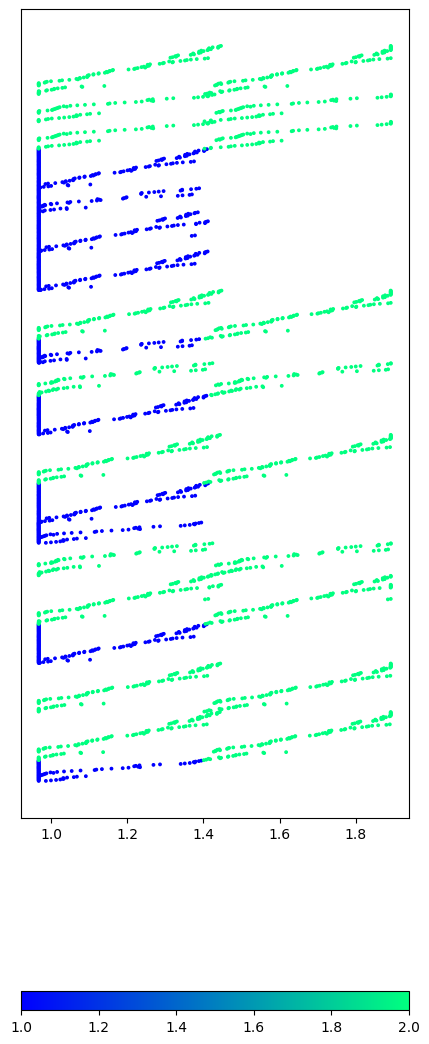

In [26]:
plt.figure(figsize=(5, 15))

idx = np.arange(len(maxwls))

plt.scatter(minwls, idx, s=3, c=ns, cmap='winter')
plt.scatter(maxwls, idx, s=3, c=ns, cmap='winter')
plt.colorbar(orientation='horizontal')
plt.yticks([]);

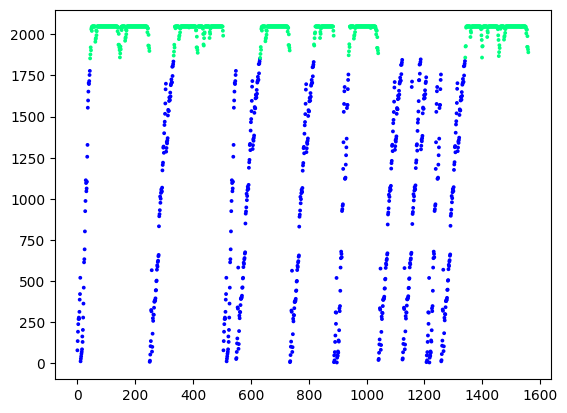

In [29]:
plt.scatter(idx, nanless_widths, s=3, c=ns, cmap='winter')

Text(0, 0.5, 'angstrom per pixel')

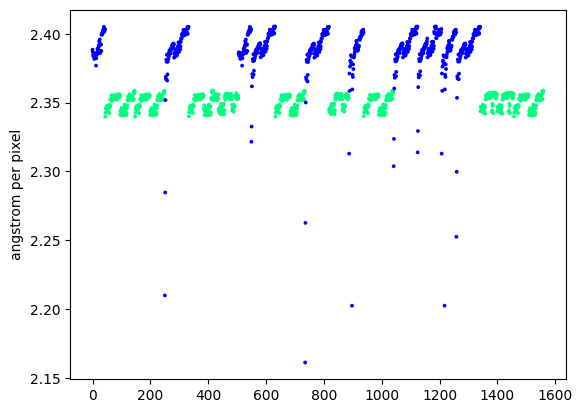

In [31]:
plt.scatter(idx,  (maxwls-minwls)*10000/nanless_widths, s=3, c=ns, cmap='winter') 
plt.ylabel('angstrom per pixel')

In [13]:
np.max(maxwls).to(u.angstrom)

<Quantity 18923.3699684 Angstrom>

In [14]:
np.min(minwls).to(u.angstrom)

<Quantity 9668.31861683 Angstrom>

In [15]:
(np.max(maxwls) - np.min(minwls)).to(u.angstrom) / (.23*u.angstrom/u.pixel)

<Quantity 40239.35370246 pix>

In [39]:
(20000-9000)*u.angstrom / (.23*u.angstrom/u.pixel)

<Quantity 47826.08695652 pix>